# Introduction to Machine Learning - PROJECT

Authors: Aino Liukonnen and Raúl Cruz-Oliver

In [7]:
import pandas as pd
# Documentation
# https://pandas.pydata.org/docs

import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Import Data
test = pd.read_excel (r'C:\Users\lenovo\Desktop\S7-DE\Introduction to Machine Learning\machine_learning_project\DATA\test.xlsx')
#this is only my path, add yours as a comment

#print(test)


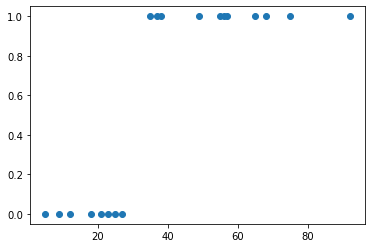

In [73]:
# Data visualization
# from data to vector
x = test["Age"].to_numpy()
y = test["Children"].to_numpy()

plt.scatter(x, y)

In [76]:
k = 1   #number of predictors, remember theta_0 is for the bias since x_o is always 1

sh=np.shape(x)
m=sh[0] #number of observations in the training data

x=np.reshape(x, (m,1)) #predictors
y=np.reshape(y, (m,1)) #labels
ones = np.ones ((m,1)) #for the bias x_0

X = np.concatenate((ones,x),axis=1) #matrix of training data

theta = np.random.rand(k+1,1)

#print(theta)
#print(X)

[[0.96015301]
 [0.45106219]]
[[ 1.  5.]
 [ 1. 25.]
 [ 1. 55.]
 [ 1. 35.]
 [ 1. 12.]
 [ 1. 75.]
 [ 1. 65.]
 [ 1. 21.]
 [ 1. 92.]
 [ 1. 37.]
 [ 1. 49.]
 [ 1.  9.]
 [ 1. 27.]
 [ 1. 68.]
 [ 1. 38.]
 [ 1. 57.]
 [ 1. 56.]
 [ 1. 23.]
 [ 1. 18.]]


In [98]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

epsilon=1.0E-03
alpha=0.1
diff=epsilon+1
theta_old=theta;

while diff > epsilon:
    theta_old=theta
    error=sigmoid(np.dot(X,theta))-y
    theta = theta_old - (alpha/m)*np.dot(np.transpose(X),error)
    diff = np.linalg.norm(theta_old-theta)
    
#print(error)
print(diff)
print(theta)

0.0009310294738678833
[[-14.52125833]
 [  0.47415708]]


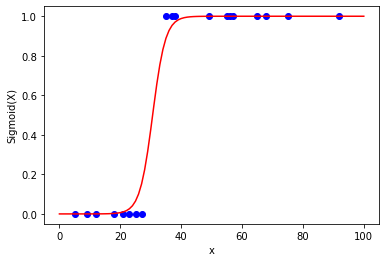

In [106]:
#trained model visualization
x_graph = np.linspace(0, 100, 101)
x_graph=np.reshape(x_graph, (101,1)) #predictors
ones = np.ones ((101,1)) #for the bias x_0
X_graph = np.concatenate((ones,x_graph),axis=1) #matrix of training data

z_graph = sigmoid(np.dot(X_graph,theta))

plt.plot(x_graph, z_graph, c="red")
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
x = test["Age"].to_numpy()
y = test["Children"].to_numpy()
plt.scatter(x, y, c="blue")